In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

from scipy.integrate import odeint
!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian

import warnings
warnings.filterwarnings('ignore')

In [2]:
def system_equations(y, t, beta, lambd, s, s1, s0, delta, delta0):
    # Parameter tetap
    d = 0.00002233251177
    b = 0.01635364431
    a = 0.3
    r = b - d
    K = 150000
    L = 10000 #tetap
    v = 0.2
    alpha = 0.000001
    Q0 = 3.216521394
    l = 0.0005 #belom diubah
    X, Y, N, B, E = y
    
    Xdot = (b - a * r * (N / K)) * N - (d + (1 - a) * r * N / K) * X - (beta * Y + lambd * B) * X + v * Y
    Ydot = (beta * Y + lambd * B) * X - (v + alpha + d + (1 - a) * r * N / K) * Y
    Ndot = r * (1 - N / K) * N - alpha * Y
    Bdot = s * B * (1 - (B / L)) + s1 * Y - s0 * B + delta * B * E
    Edot = Q0 + l * N - delta0 * E
    
    return [Xdot, Ydot, Ndot, Bdot, Edot]

In [3]:
def fit_function(t, beta, lambd, s, s1, s0, delta, delta0):
    # Initial conditions
    ya = 4750
    na = 142425
    xa = na - ya
    ba = 3.239652559
    ea = 103.5517766
    
    # Solve the ODE system
    solution = odeint(system_equations, [xa, ya, na, ba, ea], t, args=(beta, lambd, s, s1, s0, delta, delta0))
    
    X = solution[:, 0]
    Y = solution[:, 1]
    N = solution[:, 2]
    
    return Y

In [9]:
mod = lmfit.Model(fit_function)
# Set the parameters (and some initial parameter guesses)
mod.set_param_hint("beta", value=0.0000002, vary=True, min=0, max=1)
mod.set_param_hint("lambd", value=0.0000000005, vary=True, min=0,max=1)
mod.set_param_hint("s", value=75, vary=True, min=0)
mod.set_param_hint("s1", value=700.5, vary=True, min=0)
mod.set_param_hint("s0", value=22, vary=True, min=0)
mod.set_param_hint("delta", value=700 , vary=True, min=0)
mod.set_param_hint("delta0", value=300, vary=True, min=0)
params = mod.make_params()

In [10]:
# Data
t_data = np.linspace(0, 50, 8)
y_data = np.array([4750,7254,3828,2681,2796,2598,2710,2801])

N_data = np.array([142425,143276,144050,144688,145225,145623,145954,146106])  
X_data = N_data - y_data  
B_data=np.array([3.239652559,3.239652559,3.239652559,3.239652559,51.15240882,81.84385412,3.239652559,3.239652559])
E_data=np.array([103.5517766,104.1705062,104.733252,105.1971174,105.5875496,105.8769202,106.1175776,106.228091])

In [12]:
result = mod.fit(y_data, params, method="leastsq", t=t_data, X=X_data, N=N_data, B = B_data, E = E_data)  # Fitting

{'beta': 1.24695994052626e-06,
 'lambd': 3.608358611906226e-09,
 's': 0.017081765955982542,
 's1': 525676.0821603382,
 's0': 12001.44405982216,
 'delta': 700.002298772709,
 'delta0': 5039.83890373318}

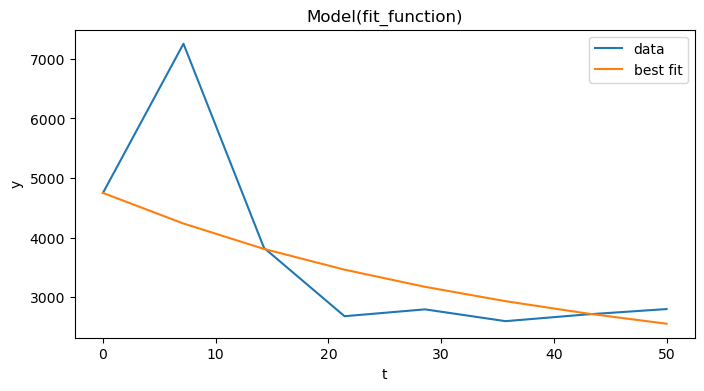

In [13]:
plt.figure(figsize=(8,4))
result.plot_fit(datafmt="-");
result.best_values

In [14]:
result